In [61]:
%load_ext pyinstrument
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import winsound
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"
import cv2

from hand_task import HAND_TASK
from cell_phone_task import CELL_PHONE_TASK
from head_task import HEAD_DIRECTION_TASK
from iris_task import IRIS_TASK
import time

iris_task = IRIS_TASK()
cell_phone_task = CELL_PHONE_TASK()
head_dir_task  = HEAD_DIRECTION_TASK()
hand_task = HAND_TASK()
tasks = [iris_task.process, cell_phone_task.process, head_dir_task.process, hand_task.process]

In [ ]:
class WinSoundController:
    def __init__(self, wav_path: str):
        self.wav_path = wav_path
        self._on = False
    def set_on(self, on: bool):
        if on and not self._on:
            winsound.PlaySound(self.wav_path,
                               winsound.SND_FILENAME | winsound.SND_ASYNC | winsound.SND_LOOP)
            self._on = True
        elif not on and self._on:
            winsound.PlaySound(None, winsound.SND_PURGE)
            self._on = False

def add_label(res):
    label = res[1]
    color = (0,0,255) if res[0] else (255,0,0)  # keep your colors
    cv2.putText(res[2], label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return res[2]

_     ._   __/__   _ _  _  _ _/_   Recorded: 10:54:15  Samples:  521
 /_//_/// /_\ / //_// / //_'/ //     Duration: 4.029     CPU time: 1.578
/   _/                      v5.1.1

Cell [73]

4.028 <module>  C:\Users\Toon\AppData\Local\Temp\ipykernel_3920\2773434768.py:1
|- 2.357 Future.result  concurrent\futures\_base.py:428
|  `- 2.356 Condition.wait  threading.py:323
|     `- 2.354 lock.acquire  <built-in>
|- 0.542 [self]  C:\Users\Toon\AppData\Local\Temp\ipykernel_3920\2773434768.py
|- 0.513 VideoCapture.read  <built-in>
|- 0.277 VideoCapture.release  <built-in>
|- 0.214 waitKey  <built-in>
`- 0.068 imshow  <built-in>
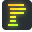

In [73]:
%%pyinstrument
cap = cv2.VideoCapture(1)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)

list_fps = []

# Use a WAV file for reliable start/stop control
sound = WinSoundController('alert.wav')
verbose = True

with ThreadPoolExecutor(max_workers=len(tasks)) as pool:
    while cap.isOpened():
        start_time = time.time()
        ret, frame = cap.read()
        if not ret:
            break

        futures = [pool.submit(func, frame.copy()) for func in tasks]
        results = [f.result() for f in futures]
        # results = [
        #     func(frame.copy()) for func in tasks
        # ]

        # --- SOUND LOGIC: play once while any alert is True; stop when all False ---
        bad_flag = any(res[0] for res in results)
        sound.set_on(bad_flag)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        time_usage =  time.time() - start_time
        list_fps.append(time_usage)
        if len(list_fps) > 60:
            del list_fps[0]

        if verbose:
            concat_images = [add_label(res) for res in results]
            result_image = np.concatenate(
                (
                    np.concatenate((concat_images[0], concat_images[1]), axis=1),
                    np.concatenate((concat_images[2], concat_images[3]), axis=1)
                ), axis=0
            )
            fps_report = f"fps:{int(len(list_fps) / sum(list_fps)):2d}"

            cv2.putText(result_image, fps_report, (30,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            cv2.imshow('result', result_image)
        
# ensure sound is stopped on exit
sound.set_on(False)
cv2.destroyAllWindows()
cap.release()

In [59]:
# import cv2
# import numpy as np

# # open both cameras
# cap0 = cv2.VideoCapture(0)
# cap0.set(cv2.CAP_PROP_BUFFERSIZE, 1)
# cap1 = cv2.VideoCapture(1)
# cap1.set(cv2.CAP_PROP_BUFFERSIZE, 1)

# hand_task2 = HAND_TASK(boundary=
#     [0.6, 0.2, 0.98, 0.9]
# )


# # Use a WAV file for reliable start/stop control
# sound = WinSoundController('alert.wav')
# verbose = True

# with ThreadPoolExecutor(max_workers=len(tasks)) as pool:
#     if not cap0.isOpened() or not cap1.isOpened():
#         print("One or both cameras could not be opened")
#         exit()

#     while True:
#         ret0, frame0 = cap0.read()
#         ret1, frame1 = cap1.read()
#         if not (ret0 and ret1):
#             break

#         # resize to same height for concatenation
#         h = min(frame0.shape[0], frame1.shape[0])
#         frame0 = cv2.resize(frame0, (int(frame0.shape[1] * h / frame0.shape[0]), h))
#         frame1 = cv2.resize(frame1, (int(frame1.shape[1] * h / frame1.shape[0]), h))
        
#         futures = [pool.submit(func, frame0.copy()) for func in tasks] + [pool.submit(hand_task2.process, frame1.copy())]
#         results = [f.result() for f in futures]

#         if verbose:
#             concat_images = [add_label(res) for res in results]
#             result_image = np.concatenate(
#                 (
#                     np.concatenate((concat_images[0], concat_images[1]), axis=1),
#                     np.concatenate((concat_images[2], concat_images[3]), axis=1)
#                 ), axis=0
#             )
#             cv2.imshow('result', result_image)
#             cv2.imshow('result2', concat_images[-1])

#             # --- SOUND LOGIC: play once while any alert is True; stop when all False ---
#             bad_flag = any(res[0] for res in results)
#             sound.set_on(bad_flag)

#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'):
#             break

# cap0.release()
# cap1.release()
# cv2.destroyAllWindows()
